In [1]:
%%capture
# Skip restarting message in Colab
import sys; modules = list(sys.modules.keys())
for x in modules: sys.modules.pop(x) if "PIL" in x or "google" in x else None

!pip install unsloth vllm
!pip install --upgrade pillow

# SFT

In [ ]:
from unsloth import FastLanguageModel, is_bfloat16_supported
import torch
max_seq_length = 2048 # Can increase for longer reasoning traces
lora_rank = 64 # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    # model_name = "unsloth/Phi-4",
    model_name="unsloth/Phi-3.5-mini-instruct",
    max_seq_length = max_seq_length,
    load_in_4bit = True, # False for LoRA 16bit
    fast_inference = True, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.7, # Reduce if out of memory
)

model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["gate_proj", "up_proj", "down_proj",],
    lora_alpha = lora_rank,
    use_gradient_checkpointing = "unsloth", # Enable long context finetuning
    random_state = 3407,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 03-11 06:21:48 __init__.py:207] Automatically detected platform cuda.
==((====))==  Unsloth 2025.3.9: Fast Llama patching. Transformers: 4.48.3. vLLM: 0.7.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/phi-3.5-mini-instruct-bnb-4bit with actual GPU utilization = 69.2%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 39.56 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 2048. Num Sequences = 320.
Unsloth: vLLM's KV Cache can use up to 24.67 G

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 03-11 06:22:12 model_runner.py:1115] Loading model weights took 2.1371 GB
INFO 03-11 06:22:12 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 03-11 06:22:16 worker.py:267] Memory profiling takes 2.65 seconds
INFO 03-11 06:22:16 worker.py:267] the current vLLM instance can use total_gpu_memory (39.56GiB) x gpu_memory_utilization (0.69) = 27.37GiB
INFO 03-11 06:22:16 worker.py:267] model weights take 2.14GiB; non_torch_memory takes 0.09GiB; PyTorch activation peak memory takes 0.39GiB; the rest of the memory reserved for KV Cache is 24.76GiB.
INFO 03-11 06:22:16 executor_base.py:111] # cuda blocks: 4225, # CPU blocks: 1024
INFO 03-11 06:22:16 executor_base.py:116] Maximum concurrency for 2048 tokens per request: 33.01x
INFO 03-11 06:22:20 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error o

Capturing CUDA graph shapes: 100%|██████████| 43/43 [00:57<00:00,  1.34s/it]

INFO 03-11 06:23:18 model_runner.py:1562] Graph capturing finished in 57 secs, took 1.09 GiB
INFO 03-11 06:23:18 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 65.32 seconds



Not an error, but Unsloth cannot patch Attention layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Not an error, but Unsloth cannot patch O projection layer with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Unsloth 2025.3.9 patched 32 layers with 0 QKV layers, 0 O layers and 32 MLP layers.


In [ ]:
from datasets import load_from_disk
from google.colab import drive

drive.mount('/content/drive')
sft_train = load_from_disk("/content/drive/MyDrive/cs234/sft_train_20k")
counts = {}
for ex in sft_train:
  counts[ex['task_type']] = counts.get(ex['task_type'], 0) + 1
print(counts)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
{'verifiable_math': 14576, 'verifiable_code': 1432, 'code_output_prediction': 1762, 'llm_judgeable_groundtruth_similarity': 2230}


In [ ]:
from trl import apply_chat_template

processed_train = sft_train.map(apply_chat_template,
                                fn_kwargs={"tokenizer": tokenizer},
                                num_proc=10,
                                remove_columns=sft_train.features)

In [ ]:
from trl import SFTConfig, SFTTrainer

train_config = SFTConfig(
    bf16=is_bfloat16_supported(),      # True
    fp16=not is_bfloat16_supported(),  # False
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    log_level="info",
    logging_strategy="steps",
    lr_scheduler_type="cosine",
    optim="paged_adamw_8bit",
    num_train_epochs=1,
    max_steps=-1,
    output_dir="./checkpoint_dir",
    overwrite_output_dir=True,
    remove_unused_columns=True,
    save_steps=10000,
    save_total_limit=1,
    seed=712,
    warmup_ratio=0.2,
    dataset_text_field="text",
    packing=True,
    report_to="none"
)

trainer = SFTTrainer(
    model=model,
    processing_class=tokenizer,
    args=train_config,
    train_dataset=processed_train,
)

trainer.train(resume_from_checkpoint=True)

PyTorch: setting up devices
PyTorch: setting up devices


Tokenizing to ["text"] (num_proc=12):   0%|          | 0/20000 [00:00<?, ? examples/s]

Packing train dataset (num_proc=12):   0%|          | 0/20000 [00:00<?, ? examples/s]

Using auto half precision backend
Loading model from ./checkpoint_dir/checkpoint-2431.
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:3441: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to

Step,Training Loss


TrainOutput(global_step=2431, training_loss=0.0, metrics={'train_runtime': 0.0139, 'train_samples_per_second': 1403802.862, 'train_steps_per_second': 175448.293, 'total_flos': 2.365688085573796e+17, 'train_loss': 0.0})

In [ ]:
# import shutil

# shutil.copytree("./checkpoint_dir", "/content/drive/MyDrive/cs234/unsloth_sft_ckpts/phi-3.5-mini-instruct/")

In [ ]:
# model.save_pretrained("/content/drive/MyDrive/cs234/unsloth_sft_ckpts/loras/phi-3.5-mini-instruct") # Local saving

# SFT Eval

In [ ]:
from unsloth import FastLanguageModel, is_bfloat16_supported
import torch
max_seq_length = 2048 # Can increase for longer reasoning traces
lora_rank = 64 # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    # model_name = "unsloth/Phi-4",
    model_name="/content/drive/MyDrive/cs234/unsloth_sft_ckpts/phi-3.5-mini-instruct/checkpoint-2431",
    max_seq_length = max_seq_length,
    load_in_4bit = True, # False for LoRA 16bit
    fast_inference = True, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.7, # Reduce if out of memory
)

FastLanguageModel.for_inference(model)

==((====))==  Unsloth 2025.3.9: Fast Llama patching. Transformers: 4.48.3. vLLM: 0.7.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/phi-3.5-mini-instruct-bnb-4bit with actual GPU utilization = 18.18%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 39.56 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 2048. Num Sequences = 192.
Unsloth: vLLM's KV Cache can use up to 4.49 GB. Also swap space = 6 GB.
INFO 03-11 06:46:48 config.py:549] This model supports multiple tasks: {'generate', 'embed', 'reward', 'score', 'classify'}. Defaulting to 'generate'.
Unsloth: vLLM Bitsandbytes config u

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 03-11 06:46:53 model_runner.py:1115] Loading model weights took 2.1129 GB
INFO 03-11 06:46:54 worker.py:267] Memory profiling takes 0.80 seconds
INFO 03-11 06:46:54 worker.py:267] the current vLLM instance can use total_gpu_memory (39.56GiB) x gpu_memory_utilization (0.18) = 7.19GiB
INFO 03-11 06:46:54 worker.py:267] model weights take 2.11GiB; non_torch_memory takes 0.00GiB; PyTorch activation peak memory takes 0.23GiB; the rest of the memory reserved for KV Cache is 4.85GiB.
INFO 03-11 06:46:54 executor_base.py:111] # cuda blocks: 827, # CPU blocks: 1024
INFO 03-11 06:46:54 executor_base.py:116] Maximum concurrency for 2048 tokens per request: 6.46x
INFO 03-11 06:46:59 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utiliza

Capturing CUDA graph shapes: 100%|██████████| 27/27 [00:39<00:00,  1.45s/it]

INFO 03-11 06:47:38 model_runner.py:1562] Graph capturing finished in 39 secs, took 0.72 GiB
INFO 03-11 06:47:38 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 45.34 seconds


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
              (k_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
              (v_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
              (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
              (rotary_emb): LlamaRotaryEmbedding()
            )
            (mlp): LlamaMLP(
              (gate_proj): lora.Linear(
                (base_layer): Linear4bit(in_features=3072, out_features=8192, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
              

In [ ]:
text = tokenizer.apply_chat_template([
    {"role" : "system", "content" : "You are an expert assistant at estimating market size, TAM, and other relevant statistics. Please box your final answer as just a single number without any units, e.g. \\boxed{{1.0}}. We will interpret your answer as being in dollars."},
    {"role": "user", "content": "What is the total market size for commercial lithographic printing in the US?"},
], tokenize = False)

text += "\n<|assistant|>\n<think>"
text = text.replace('\n<|endoftext|>', '')

print(text)

input_ids = tokenizer.encode(text, return_tensors='pt').to("cuda")
print(type(input_ids))
print(input_ids)

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt=True)

_ = model.generate(input_ids, streamer=text_streamer, max_new_tokens=4096, pad_token_id=tokenizer.eos_token_id)

<|system|>
You are an expert assistant at estimating market size, TAM, and other relevant statistics. Please box your final answer as just a single number without any units, e.g. \boxed{{1.0}}. We will interpret your answer as being in dollars.<|end|>
<|user|>
What is the total market size for commercial lithographic printing in the US?<|end|>
<|assistant|>
<think>
<class 'torch.Tensor'>
tensor([[32006,   887,   526,   385, 17924, 20255,   472,  4844,  1218,  9999,
          2159, 29892,   323,  5194, 29892,   322,   916,  8018, 13964, 29889,
          3529,  3800,   596,  2186,  1234,   408,   925,   263,  2323,  1353,
          1728,   738, 10340, 29892,   321, 29889, 29887, 29889,   320,  1884,
           287,  6224, 29896, 29889, 29900, 27243,  1334,   674,  6613,   596,
          1234,   408,  1641,   297, 17208, 29889, 32007, 32010,  1724,   338,
           278,  3001,  9999,  2159,   363, 12128,   301,   389, 12122, 14010,
           297,   278,  3148, 29973, 32007, 32001,   529

KeyboardInterrupt: 

'<|system|>\nYou are an expert assistant at estimating market size, TAM, and other relevant statistics. Please box your final answer as just a single number without any units, e.g. \\boxed{{1.0}}. We will interpret your answer as being in dollars.<|end|>\n<|user|>\nWhat is the total market size for commercial lithographic printing in the US?<|end|>\n<|assistant|>\n<think>'

# GRPO

In [2]:
from google.colab import drive

import pandas as pd

drive.mount('/content/drive')
raw_rl_data = pd.read_excel("/content/drive/MyDrive/cs234/market_stats.xlsx", usecols="A:D")

Mounted at /content/drive


In [3]:
from datasets import Dataset

def transform(row):
  system_prompt = (
    "For the following questions, please make estimates based on your knowledge only; do not consult outside sources. Respond in the following format:\n<think> ... reasoning process here ... </think>\n<answer> ... </answer>\n"
  )

  user_template = "You are an expert assistant at estimating market size, TAM, and other relevant statistics. Please box your final answer as just a single number without any units, e.g. \\boxed{{1.0}}. We will interpret your answer as being in {unit}.\n{prompt}"
  # "\n<|assistant|>\n<think>" -- will we need to manually add this? hm.

  return {
      "prompt": [
          {"role": "system", "content": system_prompt},
          {"role": "user", "content": user_template.format(unit=row["Unit"], prompt=row['Prompt'])}
      ],
      "ground_truth": row["Value"]
  }


rl_data = Dataset.from_pandas(raw_rl_data).map(transform).remove_columns(["Prompt", "Unit", "Value", "Source"])

Map:   0%|          | 0/1285 [00:00<?, ? examples/s]

In [4]:
rl_data[0]

{'prompt': [{'content': 'For the following questions, please make estimates based on your knowledge only; do not consult outside sources. Respond in the following format:\n<think> ... reasoning process here ... </think>\n<answer> ... </answer>\n',
   'role': 'system'},
  {'content': 'You are an expert assistant at estimating market size, TAM, and other relevant statistics. Please box your final answer as just a single number without any units, e.g. \\boxed{1.0}. We will interpret your answer as being in dollars.\nWhat is the total revenue of nuclear power providers in the US?',
   'role': 'user'}],
 'ground_truth': 37900000000.0}

In [5]:
# max_length = max([len(tokenizer.encode(row[0]['content'])) + len(tokenizer.encode(row[1]['content'])) for row in rl_data['prompt']])
# max_length

In [6]:
import numpy as np
import re

def accuracy_reward(completions, ground_truth, **kwargs):
  rewards = []
  for message_obj, gt in zip(completions, ground_truth):
    completion = message_obj[0]['content']
    match_obj = re.match(r"[\s\S]*<answer>(.*?)</answer>.*", completion)
    if match_obj is not None:
      raw_answer = match_obj.group(1)
      try:
        extracted_answer = float(re.sub(r"[^\d\.]", "", raw_answer))
        rewards.append(
            float((abs(extracted_answer - float(gt)) / float(gt)) <= 0.05)
        )
      except:
        rewards.append(0.0)
    else:
        rewards.append(0.0)
  return rewards


def score(x):
    # Approx. equal to 1 at |x|=0
    # Approx. equal to 0 at |x|=1
    # Assign higher reward as we get closer to |x|=0
    # R(0.5) = 0.04, R(0.25) = 0.46, R(0.1) = 0.88, ...
    # return 1 / np.sqrt(2 * np.pi * 0.1592) * np.exp(-0.5 * (x / 0.2) ** 2)
    return 1 / np.sqrt(2 * np.pi * 0.1592) * np.exp(-0.5 * (x / 0.3) ** 2)


def smoother_accuracy(completions, ground_truth, **kwargs):
  rewards = []
  for message_obj, gt in zip(completions, ground_truth):
    completion = message_obj[0]['content']
    match_obj = re.match(r"[\s\S]*<answer>(.*?)</answer>.*", completion)
    if match_obj is not None:
      raw_answer = match_obj.group(1)
      try:
        extracted_answer = float(re.sub(r"[^\d\.]", "", raw_answer))
        rewards.append(
            2 * score(float(abs(extracted_answer - float(gt))) / float(gt))
        )
      except Exception as e:
        print(e)
        rewards.append(0.0)
    else:
        rewards.append(0.0)
  return rewards


def format_reward_func(completions, ground_truth, **kwargs):
  total = 0
  pattern = r"^[\s]*<think>.*?</think>[\s]*<answer>.*?</answer>[\s]*$"
  at_least_once = [1 if re.match(pattern, completion[0]['content'], re.S) else 0 for completion in completions]
  exactly_once = [1 if len(re.findall("<think>", completion[0]['content'], re.S)) > 1 else 0 for completion in completions]
  return [((gte1 + eq1) - 1) / 5 for gte1, eq1 in zip(at_least_once, exactly_once)]


def length_penalty(completions, ground_truth, **kwargs):
  return [-len(cmpl[0]['content']) / 105400 for cmpl in completions]

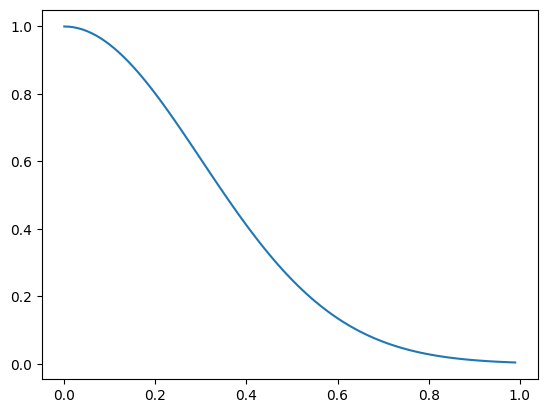

In [7]:
import matplotlib.pyplot as plt

plt.plot([i / 100 for i in list(range(100))], [score(i / 100) for i in range(100)])

In [8]:
from unsloth import FastLanguageModel, is_bfloat16_supported
import torch
max_seq_length = 512 # Can increase for longer reasoning traces
lora_rank = 64 # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Phi-3.5-mini-instruct",
    max_seq_length = max_seq_length,
    load_in_4bit = True, # False for LoRA 16bit
    fast_inference = True, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.7, # Reduce if out of memory
)

model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["gate_proj", "up_proj", "down_proj",],
)

model.load_lora("/content/drive/MyDrive/cs234/unsloth_sft_ckpts/loras/phi-3.5-mini-instruct");

Unsloth: Patching Xformers to fix some performance issues.
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 03-13 09:17:30 __init__.py:207] Automatically detected platform cuda.
==((====))==  Unsloth 2025.3.9: Fast Llama patching. Transformers: 4.48.3. vLLM: 0.7.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/phi-3.5-mini-instruct-bnb-4bit with actual GPU utilization = 69.2%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 39.56 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 512. Num Seque

tokenizer_config.json:   0%|          | 0.00/3.37k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/140 [00:00<?, ?B/s]

INFO 03-13 09:18:04 cuda.py:229] Using Flash Attention backend.
INFO 03-13 09:18:04 model_runner.py:1110] Starting to load model unsloth/phi-3.5-mini-instruct-bnb-4bit...
INFO 03-13 09:18:05 loader.py:1089] Loading weights with BitsAndBytes quantization.  May take a while ...
INFO 03-13 09:18:06 weight_utils.py:254] Using model weights format ['*.safetensors']


model.safetensors:   0%|          | 0.00/2.26G [00:00<?, ?B/s]

INFO 03-13 09:18:17 weight_utils.py:270] Time spent downloading weights for unsloth/phi-3.5-mini-instruct-bnb-4bit: 11.092789 seconds


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 03-13 09:18:20 model_runner.py:1115] Loading model weights took 2.1371 GB
INFO 03-13 09:18:20 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 03-13 09:18:29 worker.py:267] Memory profiling takes 8.83 seconds
INFO 03-13 09:18:29 worker.py:267] the current vLLM instance can use total_gpu_memory (39.56GiB) x gpu_memory_utilization (0.69) = 27.37GiB
INFO 03-13 09:18:29 worker.py:267] model weights take 2.14GiB; non_torch_memory takes 0.09GiB; PyTorch activation peak memory takes 0.38GiB; the rest of the memory reserved for KV Cache is 24.77GiB.
INFO 03-13 09:18:30 executor_base.py:111] # cuda blocks: 4226, # CPU blocks: 1024
INFO 03-13 09:18:30 executor_base.py:116] Maximum concurrency for 512 tokens per request: 132.06x
INFO 03-13 09:18:34 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error o

Capturing CUDA graph shapes: 100%|██████████| 43/43 [01:00<00:00,  1.41s/it]

INFO 03-13 09:19:35 model_runner.py:1562] Graph capturing finished in 61 secs, took 1.09 GiB
INFO 03-13 09:19:35 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 74.87 seconds


tokenizer_config.json:   0%|          | 0.00/3.37k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

Not an error, but Unsloth cannot patch Attention layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Not an error, but Unsloth cannot patch O projection layer with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Unsloth 2025.3.9 patched 32 layers with 0 QKV layers, 0 O layers and 32 MLP layers.


In [9]:
from trl import GRPOConfig, GRPOTrainer
training_args = GRPOConfig(
    use_vllm = True, # use vLLM for fast inference!
    learning_rate = 1e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "constant",
    optim = "paged_adamw_8bit",
    logging_steps = 1,
    bf16 = is_bfloat16_supported(),
    fp16 = not is_bfloat16_supported(),
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 1, # Increase to 4 for smoother training
    num_generations = 4, # Decrease if out of memory
    max_prompt_length = 256,
    max_completion_length = 1024,
    num_train_epochs = 3, # Set to 1 for a full training run
    max_steps = -1,
    save_steps = 10000,
    max_grad_norm = 0.1,
    report_to = "none", # Can use Weights & Biases
    output_dir = "./grpo_ckpts",
)

trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[smoother_accuracy, format_reward_func, length_penalty],
    args=training_args,
    train_dataset=rl_data,
)
trainer.train()

Unsloth: We now expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 4


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,285 | Num Epochs = 3 | Total steps = 3,855
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 1 x 1) = 4
 "-____-"     Trainable parameters = 69,206,016/2,078,346,240 (3.33% trained)
Unsloth: Input IDs of length 513 > the model's max sequence length of 512.
We shall truncate it ourselves. It's imperative if you correct this issue first.


Step,Training Loss,reward,reward_std,completion_length,kl,rewards / smoother_accuracy,rewards / format_reward_func,rewards / length_penalty
1,-0.000000,-0.011377,0.004255,389.000000,0.000000,0.005798,0.000000,-0.017175
2,0.000600,-0.112436,0.116831,391.000000,0.015387,0.003868,-0.100000,-0.016305
3,0.000700,-0.206988,0.010617,372.750000,0.016843,0.006776,-0.200000,-0.013764
4,0.000800,-0.114111,0.115424,379.000000,0.018766,0.000000,-0.100000,-0.014111
5,0.000900,-0.013586,0.005593,384.000000,0.023389,0.002712,0.000000,-0.016297
6,0.000700,-0.065313,0.099516,385.000000,0.017976,0.000000,-0.050000,-0.015313
7,0.000600,-0.112902,0.116595,388.000000,0.016171,0.003865,-0.100000,-0.016767
8,0.000700,0.480992,0.988938,366.000000,0.017644,0.495131,0.000000,-0.014139
9,0.000700,-0.014353,0.003924,388.000000,0.016490,0.001933,0.000000,-0.016286
10,0.000700,-0.104829,0.115716,387.000000,0.017149,0.009858,-0.100000,-0.014687


Unsloth: Will smartly offload gradients to save VRAM!
could not convert string to float: '.'
could not convert string to float: '.'
could not convert string to float: '.12..1.5'
could not convert string to float: '.800000000..'
could not convert string to float: '2.5.'
could not convert string to float: '...'
could not convert string to float: '500..'
could not convert string to float: '..'
could not convert string to float: '.'
could not convert string to float: '..'
could not convert string to float: '.'
could not convert string to float: ''
could not convert string to float: ''
could not convert string to float: '.'
could not convert string to float: '0.0225500...'
could not convert string to float: '.'
could not convert string to float: '.7.2.2.982021.7.21002.98214560...10152145632144..'
could not convert string to float: '...'
could not convert string to float: '....'
could not convert string to float: '1.2.'
could not convert string to float: '1.1252.5'
could not convert string t

KeyboardInterrupt: 

In [10]:
path_specifier = "2smooth0.3-lr1e-6-2ep--rewards-synth-only-sft-phi-3.5-mini-instruct"

In [16]:
# import shutil

# shutil.copytree("./grpo_ckpts", f"/content/drive/MyDrive/cs234/unsloth_sft_ckpts/rl_loras/{path_specifier}/trainer")

'/content/drive/MyDrive/cs234/unsloth_sft_ckpts/rl_loras/2smooth0.3-lr1e-6-2ep--rewards-synth-only-sft-phi-3.5-mini-instruct/trainer'

In [11]:
# model.save_pretrained(f"/content/drive/MyDrive/cs234/unsloth_sft_ckpts/rl_loras/{path_specifier}") # Local saving

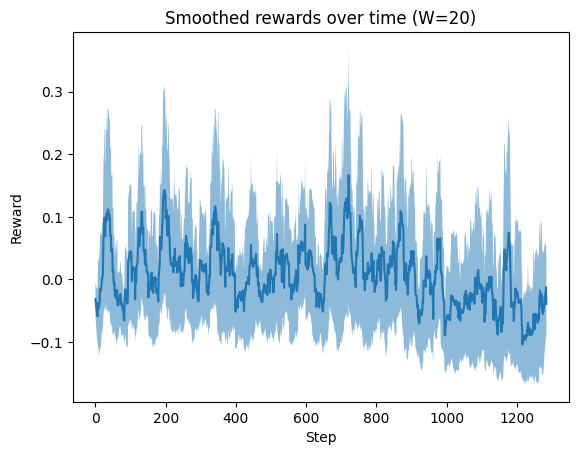

In [12]:
import matplotlib.pyplot as plt
import json

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

reward_metrics = [entry['reward'] for entry in trainer.state.log_history if 'reward' in entry]
reward_std_metrics = [entry['reward_std'] for entry in trainer.state.log_history if 'reward_std' in entry]

n_samples = 4
errors = [std / np.sqrt(n_samples) for std in reward_std_metrics]

window_size = 20
smoothed_rewards = moving_average(reward_metrics, window_size)
smoothed_stds = moving_average(reward_std_metrics, window_size)
smoothed_errors = moving_average(errors, window_size)
smoothed_lb = [val - err for val, err in zip(smoothed_rewards, smoothed_errors)]
smoothed_ub = [val + err for val, err in zip(smoothed_rewards, smoothed_errors)]

plt.plot(range(len(rl_data)), smoothed_rewards)
plt.fill_between(range(len(rl_data)), smoothed_lb, smoothed_ub, alpha=0.5)
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title(f"Smoothed rewards over time (W={window_size})")

plt.savefig(f"/content/drive/MyDrive/cs234/{path_specifier}_smoothed_rewards.png")

with open(f"/content/drive/MyDrive/cs234/{path_specifier}_metrics.json", "w") as f:
  json.dump({
      "rewards": reward_metrics,
      "stds": reward_std_metrics,
  }, f)

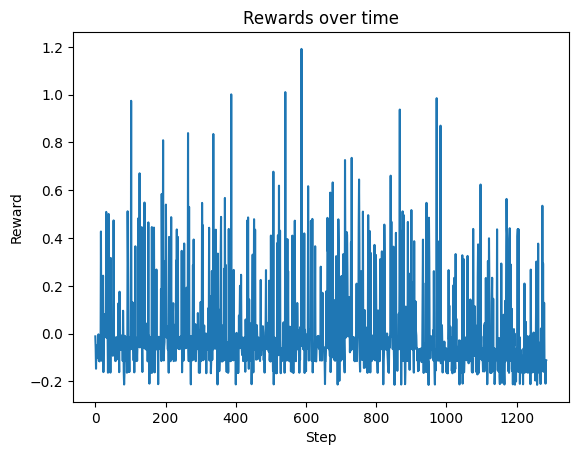

In [13]:
plt.clf()
plt.plot(range(len(rl_data)), reward_metrics)
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title(f"Rewards over time")
plt.savefig(f"/content/drive/MyDrive/cs234/{path_specifier}_rewards.png")

In [27]:
1 +1

2